In [ ]:
#@test {"skip": true}

!pip install --quiet --upgrade tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.5/558.5 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.2/365.2 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/LAB3-20221109T160610Z-001/LCL-FullData/Cluster8data.csv')

In [ ]:
data['DateTime'] = pd.to_datetime(data['DateTime'])

In [ ]:
start_date1 = pd.to_datetime('2011-10-01')
end_date1 = pd.to_datetime('2013-02-28')
filtered_data1 = data[(data['DateTime'] >= start_date1) & (data['DateTime'] <= end_date1)]


In [ ]:
# Select 20 unique LCLids
lclid_list1 = filtered_data1['LCLid'].unique()
selected_lclids1 = lclid_list1[:20]

# Filter data for the selected LCLids
f_data1 = filtered_data1[filtered_data1['LCLid'].isin(selected_lclids1)]


In [ ]:
datan1 = f_data1.copy()
datan1['KWH/hh'] = datan1['KWH/hh'].astype(np.float32)

datan1 = datan1.drop('cluster', axis=1)
datan1 = datan1.drop('stdorToU', axis=1)


In [ ]:
datan1.reset_index(drop=True, inplace=True)


In [ ]:
datan1['DateTime'] = pd.to_datetime(datan1.DateTime).dt.tz_localize(None)
for i in range(len(datan1)):
  datan1['DateTime'][i]=datan1['DateTime'][i].timestamp()

<ipython-input-12-b59380e28e58>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datan1['DateTime'][i]=datan1['DateTime'][i].timestamp()


In [ ]:
datan1['DateTime'] = datan1['DateTime'].astype(np.float32)


In [ ]:
# Sort the data by 'LCLid' and 'DateTime'
datan1.sort_values(['LCLid', 'DateTime'], inplace=True)


In [ ]:
# Define the client window dataset function for a specific LCLid
def create_client_dataset_for_LCLid(client_data, window_size, step_size):
    client_windows = []
    client_targets = []
    num_readings = len(client_data)

    # Iterate over the readings using the sliding window
    for i in range(0, num_readings - window_size, step_size):
        window_start = i
        window_end = i + window_size - 1
        prediction_index = window_end + step_size

        # Extract the window and the prediction target
        window = client_data.iloc[window_start:window_end + 1]['KWH/hh'].values
        target = client_data.iloc[prediction_index]['KWH/hh']

        client_windows.append(window)
        client_targets.append(target)

    # Create an ordered dictionary with 'x' and 'y' keys
    ordered_dict = collections.OrderedDict()
    ordered_dict['x'] = tf.stack(client_windows)
    ordered_dict['y'] = tf.expand_dims(client_targets, axis=-1)


    return ordered_dict

In [ ]:
window_size = 336
step_size = 1

# Filter the dataframe for the specific LCLid
example_LCLid = datan1['LCLid'].unique()[3]
clientyy_data = datan1[datan1['LCLid'] == example_LCLid]

# Create the client dataset for the specific LCLid
example_client_dataset = create_client_dataset_for_LCLid(clientyy_data, window_size, step_size)

print("Client dataset for LCLid", example_LCLid)
print(example_client_dataset)

Client dataset for LCLid MAC000067
OrderedDict([('x', <tf.Tensor: shape=(21112, 336), dtype=float32, numpy=
array([[0.127, 0.64 , 0.237, ..., 0.135, 0.15 , 0.174],
       [0.64 , 0.237, 0.22 , ..., 0.15 , 0.174, 0.205],
       [0.237, 0.22 , 0.215, ..., 0.174, 0.205, 0.169],
       ...,
       [0.343, 0.303, 0.303, ..., 0.129, 0.12 , 0.133],
       [0.303, 0.303, 0.322, ..., 0.12 , 0.133, 0.117],
       [0.303, 0.322, 0.268, ..., 0.133, 0.117, 0.171]], dtype=float32)>), ('y', <tf.Tensor: shape=(21112, 1), dtype=float32, numpy=
array([[0.205],
       [0.169],
       [0.116],
       ...,
       [0.117],
       [0.171],
       [0.197]], dtype=float32)>)])


In [ ]:
NUM_EPOCHS = 5
BATCH_SIZE = 12
SHUFFLE_BUFFER = 60
PREFETCH_BUFFER = 6

def preprocess_client_dataset(dataset):
    def batch_format_fn(element):
        return collections.OrderedDict(
            x=tf.reshape(element['x'], [-1, 336]),
            y=tf.reshape(element['y'], [-1, 1]))
    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
        BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)


preprocessed_example_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(example_client_dataset))


sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_client_dataset)))

sample_batch

OrderedDict([('x',
              array([[0.237, 0.22 , 0.215, ..., 0.174, 0.205, 0.169],
                     [0.381, 0.643, 0.199, ..., 0.248, 0.214, 0.217],
                     [0.22 , 0.215, 0.172, ..., 0.205, 0.169, 0.116],
                     ...,
                     [0.173, 0.192, 0.227, ..., 0.095, 0.313, 0.564],
                     [0.319, 0.232, 0.236, ..., 0.235, 0.109, 0.153],
                     [0.194, 0.196, 0.168, ..., 0.487, 0.22 , 0.282]], dtype=float32)),
             ('y',
              array([[0.116],
                     [0.235],
                     [0.146],
                     [0.108],
                     [0.128],
                     [0.169],
                     [0.246],
                     [0.226],
                     [0.273],
                     [0.253],
                     [0.093],
                     [0.24 ]], dtype=float32))])

In [ ]:
import random

NUM_CLIENTS = 15  # Replace with desired number of clients
all_clients = datan1['LCLid'].unique()
sample_clients = random.sample(all_clients.tolist(), NUM_CLIENTS)

sample_clients_list = sample_clients
sample_clients_list

['MAC000123',
 'MAC000175',
 'MAC000143',
 'MAC000154',
 'MAC000184',
 'MAC000239',
 'MAC000027',
 'MAC000241',
 'MAC000041',
 'MAC000118',
 'MAC000127',
 'MAC000033',
 'MAC000190',
 'MAC000067',
 'MAC000244']

In [ ]:
# Iterate over unique LCLids in the dataframe
client_datasets_12 = {}
for LCLid in sample_clients_list:
    # Filter the dataframe for the current LCLid
    client_data = datan1[datan1['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    client_datasets_12[LCLid] = preprocessed_client_dataset

    print("Client dataset for LCLid", LCLid)
    print(sam_batch)

Client dataset for LCLid MAC000123
OrderedDict([('x', array([[0.15 , 0.166, 0.304, ..., 0.193, 0.295, 0.217],
       [0.183, 0.164, 0.225, ..., 0.057, 0.074, 0.065],
       [0.219, 0.26 , 0.252, ..., 0.184, 0.663, 0.246],
       ...,
       [0.252, 0.26 , 0.262, ..., 0.246, 0.212, 0.213],
       [0.499, 0.35 , 0.277, ..., 0.234, 0.291, 0.273],
       [0.62 , 0.26 , 0.283, ..., 0.21 , 0.202, 0.287]], dtype=float32)), ('y', array([[0.238],
       [0.059],
       [0.212],
       [0.185],
       [0.098],
       [0.228],
       [0.959],
       [0.193],
       [0.057],
       [0.205],
       [0.305],
       [0.319]], dtype=float32))])
Client dataset for LCLid MAC000175
OrderedDict([('x', array([[0.068, 0.093, 0.065, ..., 0.092, 0.065, 0.062],
       [0.065, 0.097, 0.117, ..., 0.062, 0.085, 0.062],
       [0.198, 0.173, 0.18 , ..., 0.13 , 0.143, 0.127],
       ...,
       [0.201, 0.179, 0.17 , ..., 0.208, 0.183, 0.204],
       [0.153, 0.204, 0.176, ..., 0.083, 0.17 , 0.157],
       [0.14 , 0.

In [ ]:
def make_federated_data(client_datasets, sample_clients_list):
    return [
        client_datasets[x] for x in sample_clients_list
    ]

In [ ]:
federated_train_data_12 = make_federated_data(client_datasets_12, sample_clients)


In [ ]:
print(f'Number of client datasets: {len(federated_train_data_12)}')
print(f'First dataset: {federated_train_data_12[0]}')
print(f'Second dataset: {federated_train_data_12[1]}')

Number of client datasets: 15
First dataset: <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>
Second dataset: <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>


In [ ]:
preprocessed_example_client_dataset.element_spec

OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)),
             ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])

In [ ]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=(336,)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

In [ ]:
keras_model = create_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                21568     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 23,921
Trainable params: 23,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def model_fn():
    keras_model = create_model()
    loss = tf.keras.losses.MeanAbsoluteError()
    tff_model = tff.learning.models.from_keras_model(
        keras_model,
        input_spec=preprocessed_example_client_dataset.element_spec,
        loss=loss,
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return tff_model

In [ ]:
model = model_fn()
print(model)

In [ ]:
# training starts
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [ ]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[336,64],
      float32[64],
      float32[64,32],
      float32[32],
      float32[32,8],
      float32[8],
      float32[8,1],
      float32[1]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[336,64],
    float32[64],
    float32[64,32],
    float32[32],
    float32[32,8],
    float32[8],
    float32[8,1],
    float32[1]
  >
>@SERVER)


In [ ]:
train_state = training_process.initialize()

In [ ]:
federated_train_data_12

[<_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, n

In [ ]:
result = training_process.next(train_state, federated_train_data_12)
train_state = result.state
train_metrics = result.metrics
print('round  1, metrics={}'.format(train_metrics))

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('root_mean_squared_error', 0.11162933), ('loss', 0.060668997), ('num_examples', 1594310), ('num_batches', 132866)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


In [ ]:
NUM_ROUNDS = 21
for round_num in range(2, NUM_ROUNDS):
  result = training_process.next(train_state, federated_train_data_12)
  train_state = result.state
  train_metrics = result.metrics
  print('round {:2d}, metrics={}'.format(round_num, train_metrics))

round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('root_mean_squared_error', 0.10602063), ('loss', 0.056411844), ('num_examples', 1594310), ('num_batches', 132866)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('root_mean_squared_error', 0.10352682), ('loss', 0.05440052), ('num_examples', 1594310), ('num_batches', 132866)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  4, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('root_mean_squared_error', 0.10234188), ('loss', 0.053318873), ('num_examples', 1594310), ('num_batches', 132866)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', (

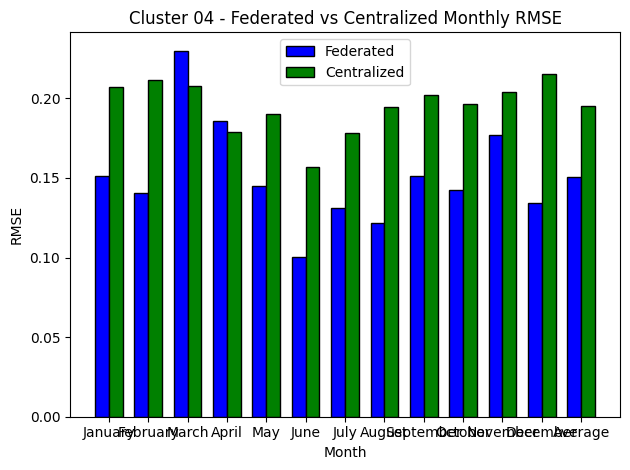

In [ ]:
import matplotlib.pyplot as plt

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Average']

federated_rmse = [0.1512, 0.1403, 0.2300, 0.1860, 0.1450, 0.1004, 0.1311, 0.1217, 0.1515, 0.1426, 0.1768, 0.1342, 0.1509]
centralized_rmse = [0.2069, 0.2114, 0.2078, 0.1789, 0.1899, 0.1570, 0.1785, 0.1943, 0.2022, 0.1963, 0.2037, 0.2152, 0.195175]

# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the X-axis
r1 = range(len(months))
r2 = [x + bar_width for x in r1]

# Create the bar graph
plt.bar(r1, federated_rmse, color='b', width=bar_width, edgecolor='black', label='Federated')
plt.bar(r2, centralized_rmse, color='g', width=bar_width, edgecolor='black', label='Centralized')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('RMSE')
plt.title('Cluster 04 - Federated vs Centralized Monthly RMSE')
plt.xticks([r + bar_width/2 for r in range(len(months))], months)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go

# Data for Cluster 08
rounds_1 = list(range(1, 21))
mae_1 = [
    0.06737575, 0.06293772, 0.060796063, 0.05940758, 0.058408998,
    0.057648093, 0.05703, 0.056526024, 0.05610915, 0.055751048,
    0.05542996, 0.055151854, 0.054903667, 0.05467346, 0.05447607,
    0.054296006, 0.054134406, 0.053993754, 0.05387066, 0.053758096
]

# Data for Cluster 09
rounds_2 = list(range(1, 21))
mae_2 = [
    0.07034567, 0.06416719, 0.061836798, 0.060558915, 0.059689056,
    0.059010174, 0.058474753, 0.058048673, 0.057682555, 0.057362556,
    0.057089813, 0.056855284, 0.056644276, 0.056458063, 0.05630099,
    0.056166247, 0.05603734, 0.055925187, 0.05582829, 0.05573636
]

# Creating trace for Cluster 08
trace1 = go.Scatter(
    x=rounds_1,
    y=mae_1,
    mode='lines',
    name='Cluster 08'
)

# Creating trace for Cluster 09
trace2 = go.Scatter(
    x=rounds_2,
    y=mae_2,
    mode='lines',
    name='Cluster 09'
)

# Creating data list
data = [trace1, trace2]

# Creating layout
layout = go.Layout(
    title='Mean Absolute Error (MAE) of Load Forecasting vs. Federated Rounds',
    xaxis=dict(title='Federated Rounds'),
    yaxis=dict(title='Training data - MAE')
)

# Creating figure
fig = go.Figure(data=data, layout=layout)

# Displaying the graph
fig.show()


In [ ]:
import plotly.graph_objects as go

# Data for Cluster 04
rounds_1 = list(range(1, 21))
mae_1 = [
    0.11573566, 0.10361333, 0.09922377, 0.09694171, 0.09549518,
    0.094502784, 0.09377624, 0.09319854, 0.09278589, 0.09244496,
    0.0921646, 0.09189611, 0.09168941, 0.09149853, 0.09130679,
    0.09120082, 0.09106272, 0.09095054, 0.09086295, 0.090747595
]

# Data for Cluster 14
rounds_2 = list(range(1, 21))
mae_2 = [
    0.1708811, 0.1584751, 0.15332645, 0.15120173, 0.14984801,
    0.14892414, 0.14833829, 0.14782089, 0.14744286, 0.14694408,
    0.14646958, 0.14602049, 0.14571527, 0.14540415, 0.14500421,
    0.1446545, 0.14432915, 0.14402962, 0.14367345, 0.14337786
]

# Creating trace for Cluster 04
trace1 = go.Scatter(
    x=rounds_1,
    y=mae_1,
    mode='lines',
    name='Cluster 04'
)

# Creating trace for Cluster 14
trace2 = go.Scatter(
    x=rounds_2,
    y=mae_2,
    mode='lines',
    name='Cluster 14'
)

# Creating data list
data = [trace1, trace2]

# Creating layout
layout = go.Layout(
    title='Mean Absolute Error (MAE) of Load Forecasting vs. Federated Rounds',
    xaxis=dict(title='Federated Rounds'),
    yaxis=dict(title='Training data - MAE')
)

# Creating figure
fig = go.Figure(data=data, layout=layout)

# Displaying the graph
fig.show()


In [ ]:
import plotly.graph_objects as go

# Data for Cluster 07
rounds_1 = list(range(1, 21))
mae_1 = [
    0.24215707, 0.22306563, 0.21767606, 0.21497612, 0.21307865,
    0.21194346, 0.21102037, 0.2100187, 0.20892245, 0.2077742,
    0.20704211, 0.20606637, 0.20509331, 0.20452215, 0.20378909,
    0.20307666, 0.2025013, 0.20195374, 0.20134038, 0.20096558
]

# Data for Cluster 18
rounds_2 = list(range(1, 21))
mae_2 = [
    0.25958988, 0.2282181, 0.21869427, 0.21352097, 0.21052141,
    0.20815776, 0.20585926, 0.2046754, 0.20356816, 0.20232281,
    0.20153011, 0.2007333, 0.20026353, 0.19920154, 0.19846562,
    0.19802547, 0.19739366, 0.19712806, 0.19636787, 0.19576551
]

# Creating trace for Cluster 07
trace1 = go.Scatter(
    x=rounds_1,
    y=mae_1,
    mode='lines',
    name='Cluster 07'
)

# Creating trace for Cluster 18
trace2 = go.Scatter(
    x=rounds_2,
    y=mae_2,
    mode='lines',
    name='Cluster 18'
)

# Creating data list
data = [trace1, trace2]

# Creating layout
layout = go.Layout(
    title='Mean Absolute Error (MAE) of Load Forecasting vs. Federated Rounds',
    xaxis=dict(title='Federated Rounds'),
    yaxis=dict(title='Training data - MAE')
)

# Creating figure
fig = go.Figure(data=data, layout=layout)

# Displaying the graph
fig.show()


In [ ]:
import plotly.graph_objects as go

# Data for Cluster - 08, Batch Size = 24, Shuffle Buffer = 120, Prefetch Buffer = 12
rounds_1 = list(range(1, 16))
mae_1 = [
    0.07406851, 0.06911341, 0.06588133, 0.06381104, 0.062328234,
    0.061173238, 0.060279164, 0.059583493, 0.059030402, 0.058575064,
    0.05819059, 0.05786198, 0.05756866, 0.05733508, 0.057126228
]

# Data for Cluster - 08, Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6
rounds_2 = list(range(1, 16))
mae_2 = [
    0.070309095, 0.06450078, 0.061607864, 0.060092628, 0.059076704,
    0.05836942, 0.057809025, 0.057371534, 0.05702302, 0.056733135,
    0.056459244, 0.056229576, 0.056033693, 0.055863913, 0.055711426
]

# Creating trace for Cluster - 08, Batch Size = 24, Shuffle Buffer = 120, Prefetch Buffer = 12
trace1 = go.Scatter(
    x=rounds_1,
    y=mae_1,
    mode='lines',
    name='Batch Size = 24, Shuffle Buffer = 120, Prefetch Buffer = 12'
)

# Creating trace for Cluster - 08, Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6
trace2 = go.Scatter(
    x=rounds_2,
    y=mae_2,
    mode='lines',
    name='Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6'
)

# Creating data list
data = [trace1, trace2]

# Creating layout
layout = go.Layout(
    title='Mean Absolute Error (MAE) vs. Federated Rounds with Learning Rate - 0.02',
    xaxis=dict(title='Federated Rounds'),
    yaxis=dict(title='MAE')
)

# Creating figure
fig = go.Figure(data=data, layout=layout)

# Displaying the graph
fig.show()


In [ ]:
import plotly.graph_objects as go

# Data for Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6, Learning Rate = 0.02
rounds_1 = list(range(1, 16))
mae_1 = [
    0.070309095, 0.06450078, 0.061607864, 0.060092628, 0.059076704,
    0.05836942, 0.057809025, 0.057371534, 0.05702302, 0.056733135,
    0.056459244, 0.056229576, 0.056033693, 0.055863913, 0.055711426
]

# Data for Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6, Learning Rate = 0.01
rounds_2 = list(range(1, 16))
mae_2 = [
    0.06575257, 0.059883647, 0.05776895, 0.056706358, 0.056026068,
    0.055522144, 0.05512807, 0.05480615, 0.054533303, 0.05431394,
    0.054116458, 0.053937282, 0.053791393, 0.05366001, 0.05353039
]

# Creating trace for Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6, Learning Rate = 0.02
trace1 = go.Scatter(
    x=rounds_1,
    y=mae_1,
    mode='lines',
    name='Learning Rate = 0.02'
)

# Creating trace for Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6, Learning Rate = 0.01
trace2 = go.Scatter(
    x=rounds_2,
    y=mae_2,
    mode='lines',
    name='Learning Rate = 0.01'
)

# Creating data list
data = [trace1, trace2]

# Creating layout
layout = go.Layout(
    title='Mean Absolute Error (MAE) vs. Federated Rounds',
    xaxis=dict(title='Federated Rounds'),
    yaxis=dict(title='MAE')
)

# Creating figure
fig = go.Figure(data=data, layout=layout)

# Displaying the graph
fig.show()


FEDERATED EVALUATION

In [ ]:
# Filter data for the specified time period
start_date = '2013-03-01'
end_date = '2014-02-28'
filtered_data = data[(data['DateTime'] >= start_date) & (data['DateTime'] <= end_date)]

# Calculate the average KWH/hh for each LCLid
average_kwh = filtered_data.groupby('LCLid')['KWH/hh'].mean()

# Find the LCLids with the lowest, highest, and medium average KWH/hh
lowest_avg_lclid = average_kwh.idxmin()
highest_avg_lclid = average_kwh.idxmax()
medium_avg_lclid = average_kwh.sort_values().index[len(average_kwh) // 2]

lowest_avg_lclid, highest_avg_lclid, medium_avg_lclid

('MAC004993', 'MAC001315', 'MAC001735')

In [ ]:
# Assuming your data is stored in a DataFrame called 'data'
# Calculate the average KWH/hh for each LCLid
average_kwh = filtered_data.groupby('LCLid')['KWH/hh'].mean()

# Print all LCLids with their corresponding average KWH/hh
for lclid, avg_kwh in average_kwh.items():
    print(f"LCLid: {lclid}, Average KWH/hh: {avg_kwh}")

LCLid: MAC000105, Average KWH/hh: 0.9795443608955938
LCLid: MAC001315, Average KWH/hh: 1.5532338398279324
LCLid: MAC001735, Average KWH/hh: 1.1353027703182235
LCLid: MAC001739, Average KWH/hh: 1.1594489043590777
LCLid: MAC002213, Average KWH/hh: 1.1571636448378426
LCLid: MAC002627, Average KWH/hh: 1.1482519873262798
LCLid: MAC002849, Average KWH/hh: 0.9751745911671925
LCLid: MAC002872, Average KWH/hh: 1.049635826832626
LCLid: MAC003257, Average KWH/hh: 1.0347555363662373
LCLid: MAC004319, Average KWH/hh: 0.9948896068466511
LCLid: MAC004593, Average KWH/hh: 1.2752311341838778
LCLid: MAC004993, Average KWH/hh: 0.7328972933569835


In [ ]:
filtered_data44 = data[data['LCLid'] == 'MAC001315']

In [ ]:
# Filter the DataFrame to include readings from Jan 01, 2014, to Jan 31, 2014
teststart_date1 = pd.to_datetime('2013-03-01')
testend_date1 = pd.to_datetime('2013-03-31')
test_data1 = filtered_data44[(filtered_data44['DateTime'] >= teststart_date1) & (filtered_data44['DateTime'] <= testend_date1)]

teststart_date2 = pd.to_datetime('2013-04-01')
testend_date2 = pd.to_datetime('2013-04-30')
test_data2 = filtered_data44[(filtered_data44['DateTime'] >= teststart_date2) & (filtered_data44['DateTime'] <= testend_date2)]


teststart_date3 = pd.to_datetime('2013-05-01')
testend_date3 = pd.to_datetime('2013-05-31')
test_data3 = filtered_data44[(filtered_data44['DateTime'] >= teststart_date3) & (filtered_data44['DateTime'] <= testend_date3)]

teststart_date4 = pd.to_datetime('2013-06-01')
testend_date4 = pd.to_datetime('2013-06-30')
test_data4 = filtered_data44[(filtered_data44['DateTime'] >= teststart_date4) & (filtered_data44['DateTime'] <= testend_date4)]

teststart_date5 = pd.to_datetime('2013-07-01')
testend_date5 = pd.to_datetime('2013-07-31')
test_data5 = filtered_data44[(filtered_data44['DateTime'] >= teststart_date5) & (filtered_data44['DateTime'] <= testend_date5)]

teststart_date6 = pd.to_datetime('2013-08-01')
testend_date6 = pd.to_datetime('2013-08-31')
test_data6 = filtered_data44[(filtered_data44['DateTime'] >= teststart_date6) & (filtered_data44['DateTime'] <= testend_date6)]

teststart_date7 = pd.to_datetime('2013-09-01')
testend_date7 = pd.to_datetime('2013-09-30')
test_data7 = filtered_data44[(filtered_data44['DateTime'] >= teststart_date7) & (filtered_data44['DateTime'] <= testend_date7)]

teststart_date8 = pd.to_datetime('2013-10-01')
testend_date8 = pd.to_datetime('2013-10-31')
test_data8 = filtered_data44[(filtered_data44['DateTime'] >= teststart_date8) & (filtered_data44['DateTime'] <= testend_date8)]

teststart_date9 = pd.to_datetime('2013-11-01')
testend_date9 = pd.to_datetime('2013-11-30')
test_data9 = filtered_data44[(filtered_data44['DateTime'] >= teststart_date9) & (filtered_data44['DateTime'] <= testend_date9)]

teststart_date10 = pd.to_datetime('2013-12-01')
testend_date10 = pd.to_datetime('2013-12-31')
test_data10 = filtered_data44[(filtered_data44['DateTime'] >= teststart_date10) & (filtered_data44['DateTime'] <= testend_date10)]

teststart_date11 = pd.to_datetime('2014-01-01')
testend_date11 = pd.to_datetime('2014-01-31')
test_data11 = filtered_data44[(filtered_data44['DateTime'] >= teststart_date11) & (filtered_data44['DateTime'] <= testend_date11)]

teststart_date12 = pd.to_datetime('2014-02-01')
testend_date12 = pd.to_datetime('2014-02-28')
test_data12 = filtered_data44[(filtered_data44['DateTime'] >= teststart_date12) & (filtered_data44['DateTime'] <= testend_date12)]



In [ ]:
test_data5

,LCLid,stdorToU,DateTime,KWH/hh,cluster
57702,MAC001315,Std,2013-07-01 00:00:00,0.823,17
57703,MAC001315,Std,2013-07-01 00:30:00,1.035,17
57704,MAC001315,Std,2013-07-01 01:00:00,0.667,17
57705,MAC001315,Std,2013-07-01 01:30:00,0.654,17
57706,MAC001315,Std,2013-07-01 02:00:00,0.710,17
...,...,...,...,...,...
59139,MAC001315,Std,2013-07-30 22:00:00,0.887,17
59140,MAC001315,Std,2013-07-30 22:30:00,0.835,17
59141,MAC001315,Std,2013-07-30 23:00:00,0.801,17
59142,MAC001315,Std,2013-07-30 23:30:00,0.815,17


In [ ]:
# Select unique LCLids
lclid_lt1 = test_data1['LCLid'].unique()
sel_lclids1 = lclid_lt1[:1]
# Filter data for the selected LCLids
ft_data1 = test_data1[test_data1['LCLid'].isin(sel_lclids1)]

# Select unique LCLids
lclid_lt2 = test_data2['LCLid'].unique()
sel_lclids2 = lclid_lt2[:1]
# Filter data for the selected LCLids
ft_data2 = test_data2[test_data2['LCLid'].isin(sel_lclids2)]

# Select unique LCLids
lclid_lt3 = test_data3['LCLid'].unique()
sel_lclids3 = lclid_lt3[:1]
# Filter data for the selected LCLids
ft_data3 = test_data3[test_data3['LCLid'].isin(sel_lclids3)]

# Select unique LCLids
lclid_lt4 = test_data4['LCLid'].unique()
sel_lclids4 = lclid_lt4[:1]
# Filter data for the selected LCLids
ft_data4 = test_data4[test_data4['LCLid'].isin(sel_lclids4)]

# Select unique LCLids
lclid_lt5 = test_data5['LCLid'].unique()
sel_lclids5 = lclid_lt5[:1]
# Filter data for the selected LCLids
ft_data5 = test_data5[test_data5['LCLid'].isin(sel_lclids5)]

# Select unique LCLids
lclid_lt6 = test_data6['LCLid'].unique()
sel_lclids6 = lclid_lt6[:1]
# Filter data for the selected LCLids
ft_data6 = test_data6[test_data6['LCLid'].isin(sel_lclids6)]

# Select unique LCLids
lclid_lt7 = test_data7['LCLid'].unique()
sel_lclids7 = lclid_lt7[:1]
# Filter data for the selected LCLids
ft_data7 = test_data7[test_data7['LCLid'].isin(sel_lclids7)]

# Select unique LCLids
lclid_lt8 = test_data8['LCLid'].unique()
sel_lclids8 = lclid_lt8[:1]
# Filter data for the selected LCLids
ft_data8 = test_data8[test_data8['LCLid'].isin(sel_lclids8)]

# Select unique LCLids
lclid_lt9 = test_data9['LCLid'].unique()
sel_lclids9 = lclid_lt9[:1]
# Filter data for the selected LCLids
ft_data9 = test_data9[test_data9['LCLid'].isin(sel_lclids9)]

# Select unique LCLids
lclid_lt10 = test_data10['LCLid'].unique()
sel_lclids10 = lclid_lt10[:1]
# Filter data for the selected LCLids
ft_data10 = test_data10[test_data10['LCLid'].isin(sel_lclids10)]

# Select unique LCLids
lclid_lt11 = test_data11['LCLid'].unique()
sel_lclids11 = lclid_lt11[:1]
# Filter data for the selected LCLids
ft_data11 = test_data11[test_data11['LCLid'].isin(sel_lclids11)]

# Select unique LCLids
lclid_lt12 = test_data12['LCLid'].unique()
sel_lclids12 = lclid_lt12[:1]
# Filter data for the selected LCLids
ft_data12 = test_data12[test_data12['LCLid'].isin(sel_lclids12)]

In [ ]:
ft_data1.reset_index(drop=True, inplace=True)
ft_data2.reset_index(drop=True, inplace=True)
ft_data3.reset_index(drop=True, inplace=True)
ft_data4.reset_index(drop=True, inplace=True)
ft_data5.reset_index(drop=True, inplace=True)
ft_data6.reset_index(drop=True, inplace=True)
ft_data7.reset_index(drop=True, inplace=True)
ft_data8.reset_index(drop=True, inplace=True)
ft_data9.reset_index(drop=True, inplace=True)
ft_data10.reset_index(drop=True, inplace=True)
ft_data11.reset_index(drop=True, inplace=True)
ft_data12.reset_index(drop=True, inplace=True)

In [ ]:
ft_data1['KWH/hh'] = ft_data1['KWH/hh'].astype(np.float32)
ft_data2['KWH/hh'] = ft_data2['KWH/hh'].astype(np.float32)
ft_data3['KWH/hh'] = ft_data3['KWH/hh'].astype(np.float32)
ft_data4['KWH/hh'] = ft_data4['KWH/hh'].astype(np.float32)
ft_data5['KWH/hh'] = ft_data5['KWH/hh'].astype(np.float32)
ft_data6['KWH/hh'] = ft_data6['KWH/hh'].astype(np.float32)
ft_data7['KWH/hh'] = ft_data7['KWH/hh'].astype(np.float32)
ft_data8['KWH/hh'] = ft_data8['KWH/hh'].astype(np.float32)
ft_data9['KWH/hh'] = ft_data9['KWH/hh'].astype(np.float32)
ft_data10['KWH/hh'] = ft_data10['KWH/hh'].astype(np.float32)
ft_data11['KWH/hh'] = ft_data11['KWH/hh'].astype(np.float32)
ft_data12['KWH/hh'] = ft_data12['KWH/hh'].astype(np.float32)


In [ ]:
ft_data1 = ft_data1.drop('cluster', axis=1)
ft_data1 = ft_data1.drop('stdorToU', axis=1)

ft_data2 = ft_data2.drop('cluster', axis=1)
ft_data2 = ft_data2.drop('stdorToU', axis=1)

ft_data3 = ft_data3.drop('cluster', axis=1)
ft_data3 = ft_data3.drop('stdorToU', axis=1)

ft_data4 = ft_data4.drop('cluster', axis=1)
ft_data4 = ft_data4.drop('stdorToU', axis=1)

ft_data5 = ft_data5.drop('cluster', axis=1)
ft_data5 = ft_data5.drop('stdorToU', axis=1)

ft_data6 = ft_data6.drop('cluster', axis=1)
ft_data6 = ft_data6.drop('stdorToU', axis=1)

ft_data7 = ft_data7.drop('cluster', axis=1)
ft_data7 = ft_data7.drop('stdorToU', axis=1)

ft_data8 = ft_data8.drop('cluster', axis=1)
ft_data8 = ft_data8.drop('stdorToU', axis=1)

ft_data9 = ft_data9.drop('cluster', axis=1)
ft_data9 = ft_data9.drop('stdorToU', axis=1)

ft_data10 = ft_data10.drop('cluster', axis=1)
ft_data10 = ft_data10.drop('stdorToU', axis=1)

ft_data11 = ft_data11.drop('cluster', axis=1)
ft_data11 = ft_data11.drop('stdorToU', axis=1)

ft_data12 = ft_data12.drop('cluster', axis=1)
ft_data12 = ft_data12.drop('stdorToU', axis=1)




In [ ]:
ft_data1['DateTime'] = pd.to_datetime(ft_data1.DateTime).dt.tz_localize(None)
for i in range(len(ft_data1)):
  ft_data1['DateTime'][i]=ft_data1['DateTime'][i].timestamp()

ft_data2['DateTime'] = pd.to_datetime(ft_data2.DateTime).dt.tz_localize(None)
for i in range(len(ft_data2)):
  ft_data2['DateTime'][i]=ft_data2['DateTime'][i].timestamp()

ft_data3['DateTime'] = pd.to_datetime(ft_data3.DateTime).dt.tz_localize(None)
for i in range(len(ft_data3)):
  ft_data3['DateTime'][i]=ft_data3['DateTime'][i].timestamp()

ft_data4['DateTime'] = pd.to_datetime(ft_data4.DateTime).dt.tz_localize(None)
for i in range(len(ft_data4)):
  ft_data4['DateTime'][i]=ft_data4['DateTime'][i].timestamp()

ft_data5['DateTime'] = pd.to_datetime(ft_data5.DateTime).dt.tz_localize(None)
for i in range(len(ft_data5)):
  ft_data5['DateTime'][i]=ft_data5['DateTime'][i].timestamp()

ft_data6['DateTime'] = pd.to_datetime(ft_data6.DateTime).dt.tz_localize(None)
for i in range(len(ft_data6)):
  ft_data6['DateTime'][i]=ft_data6['DateTime'][i].timestamp()

ft_data7['DateTime'] = pd.to_datetime(ft_data7.DateTime).dt.tz_localize(None)
for i in range(len(ft_data7)):
  ft_data7['DateTime'][i]=ft_data7['DateTime'][i].timestamp()

ft_data8['DateTime'] = pd.to_datetime(ft_data8.DateTime).dt.tz_localize(None)
for i in range(len(ft_data8)):
  ft_data8['DateTime'][i]=ft_data8['DateTime'][i].timestamp()

ft_data9['DateTime'] = pd.to_datetime(ft_data9.DateTime).dt.tz_localize(None)
for i in range(len(ft_data9)):
  ft_data9['DateTime'][i]=ft_data9['DateTime'][i].timestamp()

ft_data10['DateTime'] = pd.to_datetime(ft_data10.DateTime).dt.tz_localize(None)
for i in range(len(ft_data10)):
  ft_data10['DateTime'][i]=ft_data10['DateTime'][i].timestamp()

ft_data11['DateTime'] = pd.to_datetime(ft_data11.DateTime).dt.tz_localize(None)
for i in range(len(ft_data11)):
  ft_data11['DateTime'][i]=ft_data11['DateTime'][i].timestamp()

ft_data12['DateTime'] = pd.to_datetime(ft_data12.DateTime).dt.tz_localize(None)
for i in range(len(ft_data12)):
  ft_data12['DateTime'][i]=ft_data12['DateTime'][i].timestamp()


<ipython-input-139-1ccda807f8e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_data1['DateTime'][i]=ft_data1['DateTime'][i].timestamp()
<ipython-input-139-1ccda807f8e2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_data2['DateTime'][i]=ft_data2['DateTime'][i].timestamp()
<ipython-input-139-1ccda807f8e2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_data3['DateTime'][i]=ft_data3['DateTime'][i].timestamp()
<ipython-inp

In [ ]:
ft_data1['DateTime'] = ft_data1['DateTime'].astype(np.float32)
ft_data2['DateTime'] = ft_data2['DateTime'].astype(np.float32)
ft_data3['DateTime'] = ft_data3['DateTime'].astype(np.float32)
ft_data4['DateTime'] = ft_data4['DateTime'].astype(np.float32)
ft_data5['DateTime'] = ft_data5['DateTime'].astype(np.float32)
ft_data6['DateTime'] = ft_data6['DateTime'].astype(np.float32)
ft_data7['DateTime'] = ft_data7['DateTime'].astype(np.float32)
ft_data8['DateTime'] = ft_data8['DateTime'].astype(np.float32)
ft_data9['DateTime'] = ft_data9['DateTime'].astype(np.float32)
ft_data10['DateTime'] = ft_data10['DateTime'].astype(np.float32)
ft_data11['DateTime'] = ft_data11['DateTime'].astype(np.float32)
ft_data12['DateTime'] = ft_data12['DateTime'].astype(np.float32)




In [ ]:
# Sort the data by 'LCLid' and 'DateTime'
ft_data1.sort_values(['LCLid', 'DateTime'], inplace=True)
ft_data2.sort_values(['LCLid', 'DateTime'], inplace=True)
ft_data3.sort_values(['LCLid', 'DateTime'], inplace=True)
ft_data4.sort_values(['LCLid', 'DateTime'], inplace=True)
ft_data5.sort_values(['LCLid', 'DateTime'], inplace=True)
ft_data6.sort_values(['LCLid', 'DateTime'], inplace=True)
ft_data7.sort_values(['LCLid', 'DateTime'], inplace=True)
ft_data8.sort_values(['LCLid', 'DateTime'], inplace=True)
ft_data9.sort_values(['LCLid', 'DateTime'], inplace=True)
ft_data10.sort_values(['LCLid', 'DateTime'], inplace=True)
ft_data11.sort_values(['LCLid', 'DateTime'], inplace=True)
ft_data12.sort_values(['LCLid', 'DateTime'], inplace=True)


In [ ]:
test_client = ft_data1['LCLid'].unique()

test_client

array(['MAC001315'], dtype=object)

In [ ]:
test_dataset1 = {}

for LCLid in test_client:
    # Filter the dataframe for the current LCLid
    client_data = ft_data1[ft_data1['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    test_dataset1[LCLid] = preprocessed_client_dataset

    print("Client dataset for LCLid", LCLid)
    print(sam_batch)

Client dataset for LCLid MAC001315
OrderedDict([('x', array([[0.605, 0.541, 0.555, ..., 0.442, 0.467, 0.483],
       [0.593, 0.631, 0.674, ..., 0.582, 0.57 , 0.573],
       [0.504, 0.324, 0.358, ..., 0.431, 0.689, 0.376],
       ...,
       [0.67 , 0.655, 0.504, ..., 0.541, 0.464, 0.431],
       [0.796, 0.981, 0.93 , ..., 0.483, 0.506, 0.725],
       [1.15 , 0.532, 0.459, ..., 0.307, 0.524, 0.734]], dtype=float32)), ('y', array([[0.53 ],
       [0.594],
       [0.355],
       [0.307],
       [0.286],
       [0.593],
       [0.484],
       [0.506],
       [0.567],
       [0.689],
       [0.442],
       [0.472]], dtype=float32))])


In [ ]:
test_dataset2 = {}

for LCLid in test_client:
    # Filter the dataframe for the current LCLid
    client_data = ft_data2[ft_data2['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    test_dataset2[LCLid] = preprocessed_client_dataset


In [ ]:
test_dataset3 = {}

for LCLid in test_client:
    # Filter the dataframe for the current LCLid
    client_data = ft_data3[ft_data3['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    test_dataset3[LCLid] = preprocessed_client_dataset


In [ ]:
test_dataset4 = {}

for LCLid in test_client:
    # Filter the dataframe for the current LCLid
    client_data = ft_data4[ft_data4['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    test_dataset4[LCLid] = preprocessed_client_dataset

In [ ]:
test_dataset5 = {}

for LCLid in test_client:
    # Filter the dataframe for the current LCLid
    client_data = ft_data5[ft_data5['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    test_dataset5[LCLid] = preprocessed_client_dataset

In [ ]:
test_dataset6 = {}

for LCLid in test_client:
    # Filter the dataframe for the current LCLid
    client_data = ft_data6[ft_data6['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    test_dataset6[LCLid] = preprocessed_client_dataset

In [ ]:
test_dataset7 = {}

for LCLid in test_client:
    # Filter the dataframe for the current LCLid
    client_data = ft_data7[ft_data7['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    test_dataset7[LCLid] = preprocessed_client_dataset

In [ ]:
test_dataset8 = {}

for LCLid in test_client:
    # Filter the dataframe for the current LCLid
    client_data = ft_data8[ft_data8['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    test_dataset8[LCLid] = preprocessed_client_dataset

In [ ]:
test_dataset9 = {}

for LCLid in test_client:
    # Filter the dataframe for the current LCLid
    client_data = ft_data9[ft_data9['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    test_dataset9[LCLid] = preprocessed_client_dataset

In [ ]:
test_dataset10 = {}

for LCLid in test_client:
    # Filter the dataframe for the current LCLid
    client_data = ft_data10[ft_data10['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    test_dataset10[LCLid] = preprocessed_client_dataset

In [ ]:
test_dataset11 = {}

for LCLid in test_client:
    # Filter the dataframe for the current LCLid
    client_data = ft_data11[ft_data11['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    test_dataset11[LCLid] = preprocessed_client_dataset

In [ ]:
test_dataset12 = {}

for LCLid in test_client:
    # Filter the dataframe for the current LCLid
    client_data = ft_data12[ft_data12['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    test_dataset12[LCLid] = preprocessed_client_dataset

In [ ]:
# Make federated test data
federated_test_data1 = make_federated_data(test_dataset1, test_client)
federated_test_data2 = make_federated_data(test_dataset2, test_client)
federated_test_data3 = make_federated_data(test_dataset3, test_client)
federated_test_data4 = make_federated_data(test_dataset4, test_client)
federated_test_data5 = make_federated_data(test_dataset5, test_client)
federated_test_data6 = make_federated_data(test_dataset6, test_client)
federated_test_data7 = make_federated_data(test_dataset7, test_client)
federated_test_data8 = make_federated_data(test_dataset8, test_client)
federated_test_data9 = make_federated_data(test_dataset9, test_client)
federated_test_data10 = make_federated_data(test_dataset10, test_client)
federated_test_data11 = make_federated_data(test_dataset11, test_client)
federated_test_data12 = make_federated_data(test_dataset12, test_client)


In [ ]:
evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)

In [ ]:
print(evaluation_process.next.type_signature.formatted_representation())

(<
  state=<
    global_model_weights=<
      trainable=<
        float32[336,64],
        float32[64],
        float32[64,32],
        float32[32],
        float32[32,8],
        float32[8],
        float32[8,1],
        float32[1]
      >,
      non_trainable=<>
    >,
    distributor=<>,
    client_work=<
      <>,
      <
        root_mean_squared_error=<
          float32,
          float32
        >,
        loss=<
          float32,
          float32
        >,
        num_examples=<
          int64
        >,
        num_batches=<
          int64
        >
      >
    >,
    aggregator=<
      value_sum_process=<>,
      weight_sum_process=<>
    >,
    finalizer=<>
  >@SERVER,
  client_data={<
    x=float32[?,336],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  state=<
    global_model_weights=<
      trainable=<
        float32[336,64],
        float32[64],
        float32[64,32],
        float32[32],
        float32[32,8],
        float32[8],
        float32[8,1],
        float32

In [ ]:
evaluation_state = evaluation_process.initialize()
model_weights = training_process.get_model_weights(train_state)
evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)

In [ ]:
evaluation_output1 = evaluation_process.next(evaluation_state, federated_test_data1)
evaluation_output2 = evaluation_process.next(evaluation_state, federated_test_data2)
evaluation_output3 = evaluation_process.next(evaluation_state, federated_test_data3)
evaluation_output4 = evaluation_process.next(evaluation_state, federated_test_data4)
evaluation_output5 = evaluation_process.next(evaluation_state, federated_test_data5)
evaluation_output6 = evaluation_process.next(evaluation_state, federated_test_data6)
evaluation_output7 = evaluation_process.next(evaluation_state, federated_test_data7)
evaluation_output8 = evaluation_process.next(evaluation_state, federated_test_data8)
evaluation_output9 = evaluation_process.next(evaluation_state, federated_test_data9)
evaluation_output10 = evaluation_process.next(evaluation_state, federated_test_data10)
evaluation_output11 = evaluation_process.next(evaluation_state, federated_test_data11)
evaluation_output12 = evaluation_process.next(evaluation_state, federated_test_data12)

In [ ]:
loss_values_1 = []

# Append MAE values to the list
loss_values_1.append(evaluation_output1.metrics['client_work']['eval']['current_round_metrics']['loss'])
loss_values_1.append(evaluation_output2.metrics['client_work']['eval']['current_round_metrics']['loss'])
loss_values_1.append(evaluation_output3.metrics['client_work']['eval']['current_round_metrics']['loss'])
loss_values_1.append(evaluation_output4.metrics['client_work']['eval']['current_round_metrics']['loss'])
loss_values_1.append(evaluation_output5.metrics['client_work']['eval']['current_round_metrics']['loss'])
loss_values_1.append(evaluation_output6.metrics['client_work']['eval']['current_round_metrics']['loss'])
loss_values_1.append(evaluation_output7.metrics['client_work']['eval']['current_round_metrics']['loss'])
loss_values_1.append(evaluation_output8.metrics['client_work']['eval']['current_round_metrics']['loss'])
loss_values_1.append(evaluation_output9.metrics['client_work']['eval']['current_round_metrics']['loss'])
loss_values_1.append(evaluation_output10.metrics['client_work']['eval']['current_round_metrics']['loss'])
loss_values_1.append(evaluation_output11.metrics['client_work']['eval']['current_round_metrics']['loss'])
loss_values_1.append(evaluation_output12.metrics['client_work']['eval']['current_round_metrics']['loss'])


# Print the MAE values
print(loss_values_1)

[0.23472854, 0.21387686, 0.16562976, 0.15853234, 0.14727406, 0.15132022, 0.4900455, 0.62666476, 0.7455737, 0.71344805, 0.68575716, 0.71074927]


In [ ]:
loss_values_2 = []

# Append MAE values to the list
loss_values_2.append(evaluation_output1.metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])
loss_values_2.append(evaluation_output2.metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])
loss_values_2.append(evaluation_output3.metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])
loss_values_2.append(evaluation_output4.metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])
loss_values_2.append(evaluation_output5.metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])
loss_values_2.append(evaluation_output6.metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])
loss_values_2.append(evaluation_output7.metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])
loss_values_2.append(evaluation_output8.metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])
loss_values_2.append(evaluation_output9.metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])
loss_values_2.append(evaluation_output10.metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])
loss_values_2.append(evaluation_output11.metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])
loss_values_2.append(evaluation_output12.metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])


# Print the MAE values
print(loss_values_2)

[0.27685297, 0.25996846, 0.20401992, 0.19809169, 0.20078316, 0.193297, 0.54286844, 0.66369414, 0.7875776, 0.73726565, 0.7139394, 0.73334754]
